# Time series modeling

One of the major applications of machine learning is time series modeling, unlike the previous data we've looked at thus far, typically called panel data.  Time series data is typically called longitudinal data.

## First Example

Let's start by looking at some data.  We'll start with financial data since it's a classical example of data with some 'natural' volatility.  We'll specifically be looking at the SPY index fund.  Our ultimate goal for this example is to predict the current day.  

We'll start by downloading the data and then describing the data:

In [5]:
!python -m pip install yfinance requests pandas_datareader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 3.8 MB/s eta 0:00:00
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [78]:
import warnings
warnings.filterwarnings('ignore')

In [79]:
from pandas_datareader import data as pdr
import yfinance as yf

yf.pdr_override()

df = pdr.get_data_yahoo("SPY", start="2017-01-01", end="2023-04-30")

[*********************100%***********************]  1 of 1 completed


In [9]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,225.039993,225.830002,223.880005,225.240005,202.085266,91366500
2017-01-04,225.619995,226.750000,225.610001,226.580002,203.287521,78744400
2017-01-05,226.270004,226.580002,225.479996,226.399994,203.126038,78379000
2017-01-06,226.529999,227.750000,225.899994,227.210007,203.852753,71559900
2017-01-09,226.910004,227.070007,226.419998,226.460007,203.179871,46939700


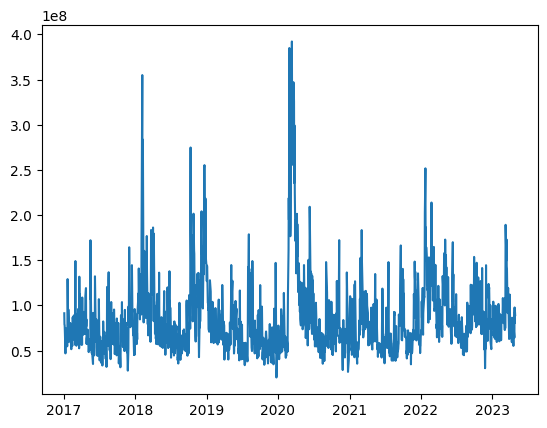

In [10]:
import matplotlib.pyplot as plt

plt.plot(df.index, df.Volume)

Timeseries data is typically described by plotting the data visually over time.  We can see the spikes and valleys in the data.  Next let's describe the average volume month over month:

In [3]:
import pandas as pd

month_year = pd.DataFrame()
month_year["month"] = df.index.month
month_year["year"] = df.index.year
month_year["day"] = 1

df["month_year"] = pd.to_datetime(month_year).values

In [47]:
print("mean volume", df["Volume"].mean())
print("variance volume", df["Volume"].var())

mean volume 84592034.88372093
variance volume 1817720496262989.5


As you can see, describing the data as point statistics doesn't really give us enough information.  Instead we'll look at what's called the moving average, on a monthly basis.

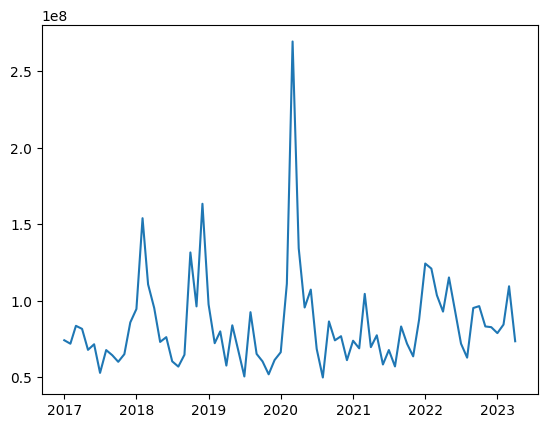

In [72]:
import pandas as pd

plt.plot(
    df["month_year"].unique(), 
    df.groupby("month_year")["Volume"].mean()
)

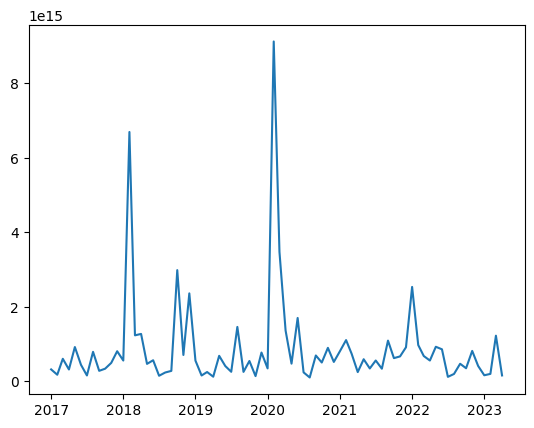

In [73]:
plt.plot(
    df["month_year"].unique(), 
    df.groupby("month_year")["Volume"].var()
)

By describing the data's monthly average and variance we get a smoothed version of the data.  This allows us to get a sense of the relative change in our descriptive statistics over time.  For instance, it appears that the relative variance was higher in the begging of 2018 compared to the mean.  Especially compared to 2019 around the same time.  Both the mean and variance spiked at the same time in 2020.  Whereas variance was slightly lower compared to mean in 2021 and 2022.

Based on the description we've seen thus far it seems fairly clear that trying to build a prediction model based on 2020 data won't be useful.  Therefore, we should start with 2021 data.  We could probably build a different model from 2017 to 2019, but things have shifted in 2020.

## Hypothesis Testing

Now that we have an intuition for what our data let's verify that, additionally we'll look at a few correlation techniques for time series data.  

Since time series data is more complex, adding the time dimension, there is a lot more description required to truly understand the components of your recorded series of data over time.  The main ideas we'll look at involve:

* understanding if we have regression to the mean 
    * serial correlation
    * autoregressive conditional heteroscedastic
* how spiky is our data 
    * structural breaks

### Understanding time series through the lens of a model

In general, when doing time series modeling we assume there is some underlying process, defined as a model that varies with time, that determines the next data point in the series.

An example model might look like:

$$ P(t) = P(t-1) + 1 * \epsilon $$

Where,
* $P(T)$ is some process
* $t$ is the current time
* $\epsilon$ is some random noise such that, $\epsilon \sim \mathcal{N}(0,1)$

So, this simple process, 'evolves' or grows over time, according to the above rule.  Let's try simulating out some examples of this process to see how it evolves over 1000 iterations:

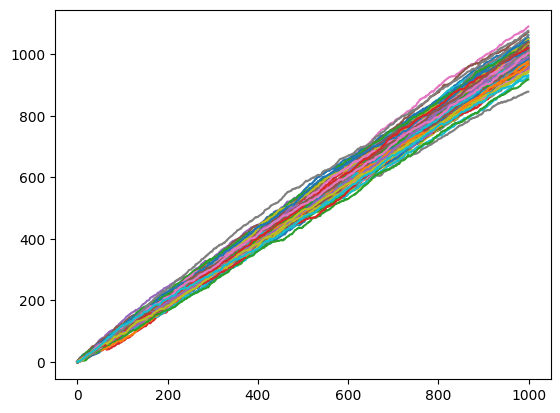

In [5]:
import random
import matplotlib.pyplot as plt

def simple_process(t):
    samples = [0 + random.gauss(0, 1)]
    for i in range(1, t):
        samples.append(
            samples[i-1] + 1 + random.gauss(0, 1)
        )
    return samples

for _ in range(100):
    y = simple_process(1000)
    x = list(range(len(y)))
    plt.plot(x, y)
plt.show()

As you can see this process is more or less linearly increasing by one with each time step.  This process exhibits a property called serial correlation because the underlying process does not regress to the mean.  A process that did would look more like this:

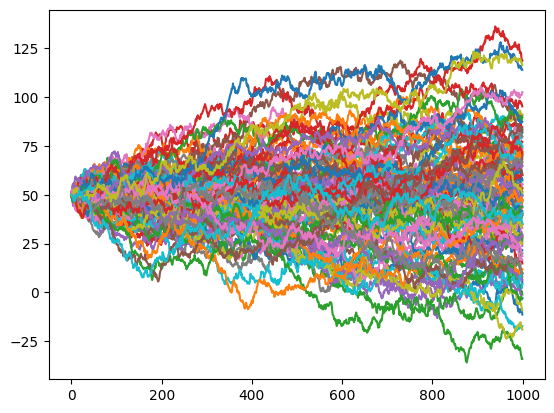

In [6]:
import random
import matplotlib.pyplot as plt

def regress_to_mean_process(t):
    samples = [50]
    for i in range(1, t):
        samples.append(
            samples[i-1] + random.gauss(0, 1)
        )
    return samples

for _ in range(100):
    y = regress_to_mean_process(1000)
    x = list(range(len(y)))
    plt.plot(x, y)
plt.show()

As you can see, the processes do 'fan' out, but there is no clear upward or downward trend like in the previous example.  That's because the cause of the increase or decrease of the series is random noise.  Any process that exhibits serial correlation likely has some notion of trend, or increase or decrease with time.  Some people believe the stock market or the house market in the united states are such markets, where prices go up forever.  

This, juxtaposed with systems that have reached satiation, have reached either their 'carrying capacity', that is roughly the maximum they can hold and therefore do not vary much except for random noise.  Processes that are uncorrelated over time only change because of 'shocks' to the system that temporarily force them out of equilibrium.  As an aside, the foundation of economics is that all markets reach this satiation point if unchecked or if not subject to random shocks that distabilize the market.  Therefore, one could argue the continued growth of the large US markets fly in the face of economic theory, or it's unlikely prices will continue to increase forever and that eventually prices will reach satiation and thus no more extra growth in these sectors will occur, assuming economic theory is correct.

My point with this is subtle one, I am not trying to say economists are wrong; I am trying to indicate serial correlation (as many other texts would state) is not always a bad thing, it is merely a feature or behavior of some systems.  Should all processes equilibriate and thus be 'easy' for us to study?  I think not.  Our tools should conform to the world, the world should not conform to our tools.  

None the less, we should know which regime we are in and act accordingly. 

### Testing for Serial Correlation

Now that we understand that serial correlation is something we can check for, let's look at a statistical test to look for it.  We'll be looking at the unit root test for serial correlation:

In [12]:
from statsmodels.tsa.stattools import adfuller

mean_volume = df.groupby("month_year")["Volume"].mean().values

res = adfuller(mean_volume)
print('ADF Statistic: %f' % res[0])
print('p-value: %f' % res[1])
print('Critical Values:')

for key, value in res[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.590631
p-value: 0.000001
Critical Values:
	1%: -3.521
	5%: -2.901
	10%: -2.588


We can safely reject the null hypothesis so there is no unit root for the mean of the SPY stock market index fund.  So perhaps markets do equilibriate over a certain time frame!

Let's look at the variance of the Volume:

In [13]:
variance_volume = df.groupby("month_year")["Volume"].var()

res = adfuller(variance_volume)
print('ADF Statistic: %f' % res[0])
print('p-value: %f' % res[1])
print('Critical Values:')

for key, value in res[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.659340
p-value: 0.004723
Critical Values:
	1%: -3.522
	5%: -2.901
	10%: -2.588


Again we reject the null hypothesis of a unit root, but this time by much less.  Next let's just look at the Volume over the full time frame:

In [14]:
res = adfuller(df["Volume"])
print('ADF Statistic: %f' % res[0])
print('p-value: %f' % res[1])
print('Critical Values:')

for key, value in res[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.085588
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Here we strongly reject the null hypothesis of a unit root, so we can conclude there is no serial correlation in Volume, period.  

This tells us something very important - the deman and supply of stocks is more or less in equilibrium.  It doesn't mean the actual price of stocks is a stationary process, but at least the volume of demand for buying and selling stocks is fairly fixed, which means sense.  Most stocks are bought buy hedge funds, pensions and individual 401k's and those pretty much buy at a standard rate.  With few people trying to do very 'risky' trading.

Next let's look at the actual process - we'll use the Open prices over time for this analysis:

In [15]:
res = adfuller(df["Open"])
print('ADF Statistic: %f' % res[0])
print('p-value: %f' % res[1])
print('Critical Values:')

for key, value in res[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.275258
p-value: 0.640414
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Interestingly, the prices themselves DO exhibit fairly clear serial correlation, indicating that while volume is in equilbrium, the actual price bought and sold does seem to increase over time.  Let's look at this visually:

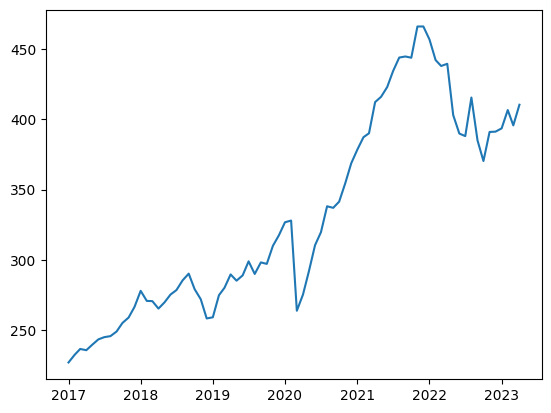

In [16]:
plt.plot(
    df["month_year"].unique(), 
    df.groupby("month_year")["Open"].mean()
)

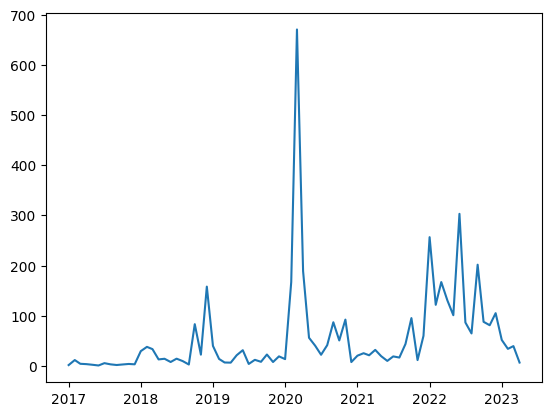

In [17]:
plt.plot(
    df["month_year"].unique(), 
    df.groupby("month_year")["Open"].var()
)

It does appear as though there is a fairly clear positive trend on the mean of the open pricess and the volatility generally seems to be shifting over time especially in 2022.  

I believe we are now in a place to build a model.

## Training Data

Training a model for time series is different than with panel data.  Let's look at a few ways to train a time series model.  

First we'll look at training a model by looking at the immediate past:

In [33]:
def generate_dataset(df, column, shift_range=7):
    for i in range(1, shift_range):
        shift = i * -1
        df[f"{column}_shifted_{i}"] = df[column].shift(shift)
    columns = df.columns.tolist()
    columns = [col for col in columns if column in col]
    return df[columns].dropna()

sample = df[df.index.year > 2020]
open_training = generate_dataset(sample, "Open", shift_range=7)

89.0748852169573


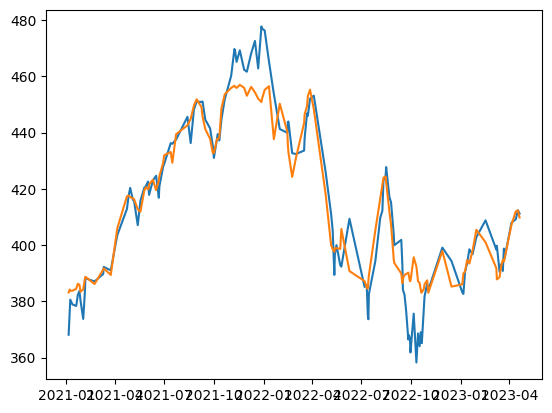

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error 
import matplotlib.pyplot as plt

y = open_training["Open"]
open_training = open_training.drop("Open", axis=1)
X = open_training
X_train, X_test, y_train, y_test = train_test_split(X, y)
model = SVR()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(mean_squared_error(y_pred, y_test))
viz_results_df = X_test.copy()
viz_results_df["y_test"] = y_test
viz_results_df["y_pred"] = y_pred
viz_results_df.sort_index(inplace=True)
plt.plot(viz_results_df.index, viz_results_df["y_test"])
plt.plot(viz_results_df.index, viz_results_df["y_pred"])

As you can see, setting our features for the week before is pretty good!  As our mean squared error shows - we are only off by $ \sqrt{30} $ on average.  The reason this is the square root is because we square the average error to account for negatives in our data.  Mean squared error also 'exaggerates' the error to some degree so we aren't over confident in our results.  This also makes it an ideal training loss, because errors are more strongly penalized.  

The graph shows us that our predictions (in orange) fairly closely track our actual open data (in blue), this means we can fairly confidently price this index fund over this period!  It's important to realize the limitations of this model:

1.  We can only predict about 1 day out
2.  We selected a period of relatively low volatility and normal behavior, ensuring our model would do a decent job
3.  We are only predicting the open price, not accounting for the intra day volatility in the price, so our option must be executed at market open.

Even with these limitations, we can still make some reasonable guarantees about returns, assuming we account for our risks.  This part is an aside, but by using options instead of directly buying and selling stocks, we can mitigate the risks of our model and thus make returns.

Now that we have one method to account for time series data, let's look at a second 'weaker' method, explicitly bringing in a time dimension:

In [35]:
def generate_dataset_with_index(df):
    df["time_index"] = list(range(df.shape[0]))
    df["yesterday_close"] = df["Close"].shift(1)
    columns = [
        "time_index",
        "yesterday_close",
        "Open"
    ]
    return df[columns].dropna()

sample = df[df.index.year > 2020]
open_training = generate_dataset_with_index(sample)

124.50174821875216


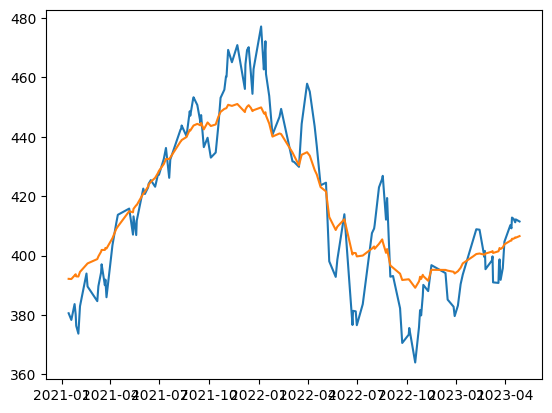

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error 
import matplotlib.pyplot as plt

y = open_training["Open"]
open_training = open_training.drop("Open", axis=1)
X = open_training
X_train, X_test, y_train, y_test = train_test_split(X, y)
model = SVR()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(mean_squared_error(y_pred, y_test))
viz_results_df = X_test.copy()
viz_results_df["y_test"] = y_test
viz_results_df["y_pred"] = y_pred
viz_results_df.sort_index(inplace=True)
plt.plot(viz_results_df.index, viz_results_df["y_test"])
plt.plot(viz_results_df.index, viz_results_df["y_pred"])

As you can see, our model still does a reasonable job but captures less of the variation when trained only on yesterday's close and an index variable, which accounts for the time component of our model, explicitly.  Let's see what happens if we combine the two techniques together.  Here we will use the previous open prices and the previous day's close as well as the index variable as features for our output variable, the open price on a given day.

In [37]:
def generate_dataset_with_index_and_previous_days(df, column, shift_range=7):
    df["time_index"] = list(range(df.shape[0]))
    df["yesterday_close"] = df["Close"].shift(1)
    feature_names = []
    for i in range(1, shift_range):
        shift = i * -1
        feature_name = f"{column}_shifted_{i}"
        feature_names.append(feature_name)
        df[feature_name] = df[column].shift(shift)
    columns = [
        "time_index",
        "yesterday_close",
        "Open",
    ] + feature_names
    return df[columns].dropna()

sample = df[df.index.year > 2020]
open_training = generate_dataset_with_index_and_previous_days(sample, "Open")

72.44501277426936


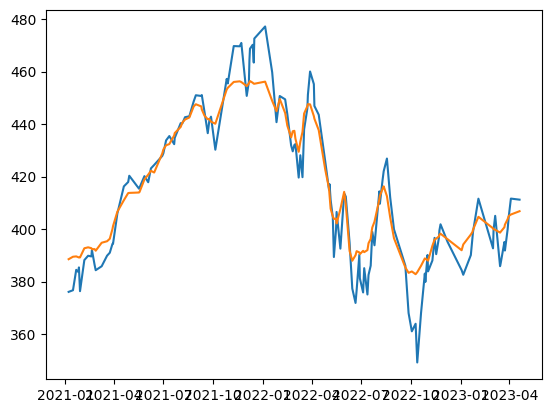

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error 
import matplotlib.pyplot as plt

y = open_training["Open"]
open_training = open_training.drop("Open", axis=1)
X = open_training
X_train, X_test, y_train, y_test = train_test_split(X, y)
model = SVR()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(mean_squared_error(y_pred, y_test))
viz_results_df = X_test.copy()
viz_results_df["y_test"] = y_test
viz_results_df["y_pred"] = y_pred
viz_results_df.sort_index(inplace=True)
plt.plot(viz_results_df.index, viz_results_df["y_test"])
plt.plot(viz_results_df.index, viz_results_df["y_pred"])

As you can see, this model is more conservative than the model that just uses the previous 7 days alone but less conservative than the model that just uses the previous close price.  This seems more or less perfect for multi-day predictions since we won't get caught too deeply in the wrong direction if our model makes a bad guess.  

Next we'll look at generating predictions for multiple days in a row.  For this we'll simply do a naive train test split, predicting the last 10 days in a row.  We'll see a better method for dealing with multiple day predictions later on in the chapter.

For this model we'll need to predict the open price for the next day sequentially, we won't be able to use the close price on the previous day, since then we'd have to have two models, which would be far more error prone.  Since we are trying to forecast a full 10 days out we'll look at the error along the way, but we will be most interested in the final error, that is the error on the 10th day.

117.81968280402297


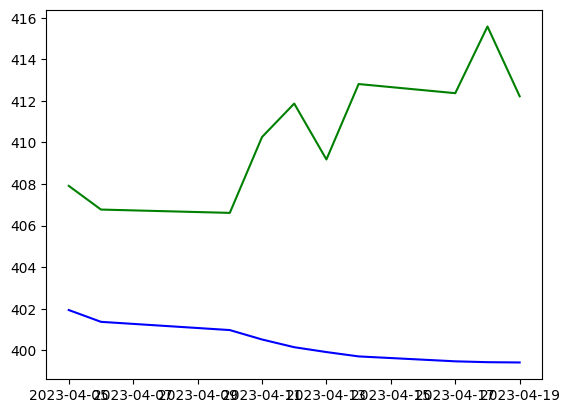

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error 
import matplotlib.pyplot as plt

def generate_dataset_with_index_and_previous_days2(df, column, shift_range=8):
    df["time_index"] = list(range(df.shape[0]))
    feature_names = []
    for i in range(1, shift_range):
        shift = i * -1
        feature_name = f"{column}_shifted_{i}"
        feature_names.append(feature_name)
        df[feature_name] = df[column].shift(shift)
    columns = [
        "time_index",
        "Open",
    ] + feature_names
    return df[columns].dropna()

def generate_predictions(X_train, model):
    predictions = pd.DataFrame({
        "time_index": X_train["time_index"].iloc[-1] + 1,
        "Open_shifted_1": model.predict(X_train.iloc[-1].values.reshape(1, -1))[0],
        "Open_shifted_2": X_train["Open_shifted_1"].iloc[-1],
        "Open_shifted_3": X_train["Open_shifted_2"].iloc[-1],
        "Open_shifted_4": X_train["Open_shifted_3"].iloc[-1],
        "Open_shifted_5": X_train["Open_shifted_4"].iloc[-1],
        "Open_shifted_6": X_train["Open_shifted_5"].iloc[-1],
        "Open_shifted_7": X_train["Open_shifted_6"].iloc[-1]
        
    }, index=[0])
    for i in range(2, 11):
        prediction = {
            "time_index": X_train["time_index"].iloc[-1] + i,
            "Open_shifted_1": model.predict(predictions.iloc[-1].values.reshape(1, -1))[0]
        }
        for i in range(2, 8):
            prediction[f"Open_shifted_{i}"] = predictions[f"Open_shifted_{i-1}"].iloc[-1]
        predictions = predictions.append(prediction, ignore_index=True)
    return predictions

sample = df[df.index.year > 2020]
open_training = generate_dataset_with_index_and_previous_days2(sample, "Open")

y = open_training["Open"]
open_training = open_training.drop("Open", axis=1)
X = open_training
X_train = X[:-10]
X_test = X[-10:]
y_train = y[:-10]
y_test = y[-10:]
model = SVR()
model.fit(X_train, y_train)
predictions = generate_predictions(X_train, model)
print(mean_squared_error(predictions["Open_shifted_1"].values, y_test))
viz_results_df = X_test.copy()
viz_results_df["y_test"] = y_test
viz_results_df["y_pred"] = predictions["Open_shifted_1"].values
viz_results_df.sort_index(inplace=True)
plt.plot(viz_results_df.index, viz_results_df["y_test"], color="green")
plt.plot(viz_results_df.index, viz_results_df["y_pred"], color="blue")
plt.show()

Not too bad!  This may seem terrible, but that's only relatively.  These values are actually quiet close!  Even if the direction is clearly wrong.  We don't have enough test data to really check whether or not we are doing a decent job.  We'll address this issue with a novel technique (not one of mine but from an arXiv article).  Next let's try to predict 10 days out, as a point statistic, rather than trying to predict a series of days in a row:

118.2422026472258


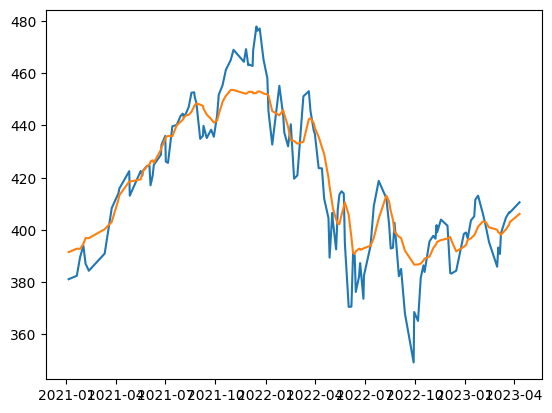

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error 
import matplotlib.pyplot as plt

def generate_dataset_with_index_and_previous_days3(df, shift_range=8):
    df["time_index"] = list(range(df.shape[0]))
    df["most_recent_close"] = df["Close"].shift(1)
    feature_names = []
    for i in range(1, shift_range):
        shift = i * -1
        feature_name = f"Open_shifted_{i}"
        feature_names.append(feature_name)
        df[feature_name] = df["Open"].shift(shift)
    df["target"] = df["Open"].shift(-10)
    columns = [
        "time_index",
        "target",
        "most_recent_close",
    ] + feature_names
    return df[columns].dropna()

sample = df[df.index.year > 2020]
open_training = generate_dataset_with_index_and_previous_days3(sample)

y = open_training["target"]
open_training = open_training.drop("target", axis=1)
X = open_training
X_train, X_test, y_train, y_test = train_test_split(X, y)
model = SVR()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(mean_squared_error(y_pred, y_test))
viz_results_df = X_test.copy()
viz_results_df["y_test"] = y_test
viz_results_df["y_pred"] = y_pred
viz_results_df.sort_index(inplace=True)
plt.plot(viz_results_df.index, viz_results_df["y_test"])
plt.plot(viz_results_df.index, viz_results_df["y_pred"])

Not too bad!  Looks like we can capture the general structure of our series, even 10 days out!  Our individual predictions will sometimes be wrong.  Which is not ideal.  So, an important question arises, can we do better?

One way to assess this would be to look at which signals covary with our Open price and include them as features in our model.  There are a few concepts we'll need in order to statistically test if two series are correlated.

## Cointegration

Cointegration implies there is a relationship between two or more series.  Recall from earlier in the chapter that a series can either be serially correlated or not serially correlated.  Series' that do regress to the mean are considered 'stationary' series' because of this regression to the mean property, in other words, there is no trend.  

In order to understand cointegration we'll first need to understand integration.  This is not integration from calculus.  In time series statistics, integration refers to the number of differences one needs to take of the series with itself in order to remove all the non-stationary components.  

This point is being brought up for a few reasons, to lightly touch on signal processing - which says that all series can be 'decomposed' into a set of simpler signals until you get to a series of sine and cosine waves (which is a striking result!).  This allows us to realize that it is possible to 'difference' out these marginal effects by simple subtraction.

Let's look at an example, using our above series.  Recall that the "Open" price of SPY is serially correlated:

In [80]:
from statsmodels.tsa.stattools import adfuller

res = adfuller(df["Open"])
print('ADF Statistic: %f' % res[0])
print('p-value: %f' % res[1])
print('Critical Values:')

for key, value in res[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.275258
p-value: 0.640414
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Now let's difference and test if our series is no longer serially correlated:

In [85]:
series = df["Open"].copy()
open_prices = pd.DataFrame()
open_prices["open"] = series.values
for i in range(1, 10):
    open_prices[f"y_t-{i}"] = series.values
    open_prices[f"y_t-{i}"] = open_prices[f"y_t-{i}"].shift(i * -1)
open_prices = open_prices.dropna(axis=0)

series = open_prices["open"].copy()
for i in range(1, 10):
    series -= open_prices[f"y_t-{i}"]
    res = adfuller(series)
    print('ADF Statistic: %f' % res[0])
    print('p-value: %f' % res[1])
    print('Critical Values:')

    for key, value in res[4].items():
        print('\t%s: %.3f' % (key, value))


ADF Statistic: -41.878334
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
ADF Statistic: -1.244067
p-value: 0.654358
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
ADF Statistic: -1.262310
p-value: 0.646234
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
ADF Statistic: -1.180434
p-value: 0.681955
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
ADF Statistic: -1.140824
p-value: 0.698520
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
ADF Statistic: -1.159106
p-value: 0.690935
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
ADF Statistic: -1.164727
p-value: 0.688582
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
ADF Statistic: -1.149440
p-value: 0.694959
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
ADF Statistic: -1.126616
p-value: 0.704342
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568


As you can see 